In [23]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
from information_scores import *

rcParams.update({'font.size': 18})

In [24]:
data_path = 'dataset/BZ.mat'

arrays = {}
f = h5py.File(data_path,'r')
for k, v in f.items():
    arrays[k] = np.array(v)
    
BZ_tensor = np.asarray(arrays.get("BZ_tensor"))

[k,m,n] = BZ_tensor.shape # obtain the dimensions of the tensor
print(m,n,k) # print out the shape of the tensor as a sanity check

451 351 1200


In [3]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [31]:
# Obtain data matrices 
tile_dim = 300
k = 300
BZ_tensor = BZ_tensor[:k,:,:]

X = BZ_tensor[:-1,0:tile_dim,0:tile_dim]
X.shape
X = X.reshape((k-1,tile_dim**2))
Xprime = BZ_tensor[1:,0:tile_dim,0:tile_dim]
Xprime = Xprime.reshape((k-1,tile_dim**2))

X = X.T
Xprime = Xprime.T

print(X.shape,Xprime.shape)

(90000, 299) (90000, 299)


In [32]:
# obtain DMD model
dt = 0.2
r = 20 # enter the value of r
Phi, Lambda, b = DMD(X[:,:],Xprime[:,:],r)
omega = np.log(np.diag(Lambda))/dt

In [33]:
Phi.shape

(90000, 20)

In [34]:
# reconstruct dynamics with DMD as a sanity check

time_oscillator = np.arange(0,k,dt)

time_dynamics = np.zeros([Phi.shape[1],k])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*time_oscillator[i])
    
X_dmd = np.abs(np.dot(Phi,time_dynamics))
X_dmd = X_dmd.reshape((k,tile_dim,tile_dim))

print(X_dmd.shape)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


(300, 300, 300)


Text(0.5, 1.0, 'reconstructed')

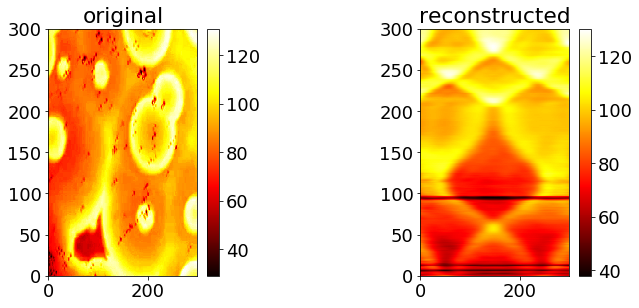

In [35]:
j = 1

plt.rcParams['figure.figsize'] = [10, 10]
plt.subplots_adjust(wspace = 1)

plt.subplot(2,2,1)
x_pcolor = plt.pcolor(BZ_tensor[j,:tile_dim,:tile_dim],cmap='hot')
plt.colorbar(x_pcolor)
plt.title('original')

plt.subplot(2,2,2)
x_pcolor = plt.pcolor(X_dmd[j,:,:],cmap='hot')
plt.colorbar(x_pcolor)
plt.title('reconstructed')

# plt.subplot(2,2,3)
# x_pcolor = plt.pcolor(BZ_tensor[j+5,:tile_dim,:tile_dim],cmap='hot')
# plt.colorbar(x_pcolor)

# plt.subplot(2,2,4)
# x_pcolor = plt.pcolor(X_dmd[j+5,:,:],cmap='hot')
# plt.colorbar(x_pcolor)